## **Dependencies**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## **Splitting Cam Images (928 x 1280) into 2 Total Images: 1 Multispectral Image (928 x 640) and 1 RGB Image (928 x 640)**

In [ ]:
def process_rgb_images(input_folder, output_folder_rgb):
    # List all camera folders
    cam_folders = [f'cam{i}' for i in range(1, 9)]

    for cam in cam_folders:
        cam_path = os.path.join(input_folder, cam)
        output_cam_rgb_path = os.path.join(output_folder_rgb, f'{cam}_rgb')
        
        os.makedirs(output_cam_rgb_path, exist_ok=True)
        
        # List all image files in the current camera folder
        for filename in os.listdir(cam_path):
            if filename.endswith('.png'):
                image_path = os.path.join(cam_path, filename)
                
                # Open the image
                img = Image.open(image_path)
                
                # Check the image size to ensure it is 1280 x 928
                if img.size != (1280, 928):
                    print(f"Skipping {image_path}: unexpected image size {img.size}")
                    continue
                
                # Split the image to get the right half
                right_half = img.crop((640, 0, 1280, 928))
                
                # Save the right half
                right_half.save(os.path.join(output_cam_rgb_path, f'{os.path.splitext(filename)[0]}{os.path.splitext(filename)[1]}'))
                
                print(f"Processed right side of {filename}")

def process_nir_images(input_folder, output_folder_ir):
    # List all camera folders
    cam_folders = [f'cam{i}' for i in range(1, 9)]

    for cam in cam_folders:
        cam_path = os.path.join(input_folder, cam)
        output_cam_ir_path = os.path.join(output_folder_ir, f'{cam}_nir')
        
        os.makedirs(output_cam_ir_path, exist_ok=True)
        
        # List all image files in the current camera folder
        for filename in os.listdir(cam_path):
            if filename.endswith('.png'):
                image_path = os.path.join(cam_path, filename)
                
                # Open the image
                img = Image.open(image_path)
                
                # Check the image size to ensure it is 1280 x 928
                if img.size != (1280, 928):
                    print(f"Skipping {image_path}: unexpected image size {img.size}")
                    continue
                
                # Split the image to get the left half
                left_half = img.crop((0, 0, 640, 928))
                
                # Save the left half
                left_half.save(os.path.join(output_cam_ir_path, f'{os.path.splitext(filename)[0]}{os.path.splitext(filename)[1]}'))
                
                print(f"Processed left side of {filename}")

# Input and output folders
input_folder = '../data'
output_folder_rgb = '../data/'
output_folder_ir = '../data/'

# Run the functions
# process_rgb_images(input_folder, output_folder_rgb)
process_nir_images(input_folder, output_folder_ir)

### Step 1: Do Radiometric Reflectance Correction on Reference Panels ✔️
### Step 2: Labelling - aka Find ROIs (Region of Interests)
### Step ???: Use AlexNet to Segment Wheat Plot Fields
### Step 3: Compute VI (Vegetation Indices)
### Step 4: Extract Data -> Summaries

## **Calculating Radiometric Reflectance on Reference Panels**

find the average value of RGB, NIR of gray panel for each image...
Then, divide each pixek in R band by average value of gray panel in red band.  repeat this for 6 bands. This becom4es reflectance image.
Register NRI images to RGB images.  You could even use the gray panel is registration points...
Calculate NDVI at each pixel.
NDFVI = (NRI-Red)/(NRI+red).  But you have 3 NIR bands.  Which one should be used?
Either segment whole wheat field from reflectance image or NDVI image.
Then, use logic to divide the wheat field into plots.
Find ststaitsics of NDVI from each plot

### Reordering CSV files in the `model_output` directory

In [ ]:
import os
import pandas as pd

# Define the naming conventions and range
prefixes = [f'cam{i}' for i in range(1, 9)]
suffixes = ['_nir.csv', '_rgb.csv']

# Get list of CSV files in the directory
all_files = os.listdir('../model_output/')
csv_files = [f for f in all_files if any(f.startswith(prefix) and f.endswith(suffix) for prefix in prefixes for suffix in suffixes)]

# Process each CSV file
for csv_file in csv_files:
    # Read the CSV file
    file_path = f'../model_output/{csv_file}'
    df = pd.read_csv(file_path)
    
    # Remove rows with NaN in Center_X or Center_Y
    df = df.dropna(subset=['Center_X', 'Center_Y'])
    
    # Sort by Filename
    df = df.sort_values(by='Filename')
    
    # Save the cleaned and sorted dataframe back to the CSV file
    df.to_csv(file_path, index=False)
    
    print(f"Processed {csv_file}")

### Saving Plots in the `assets` directory

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Go through each camera and plot the Center_X and Center_Y values
output_folder = '../assets'

for i in range(1, 9):
    # Plot for cam{i}_nir.csv
    nir_df = pd.read_csv(f'../model_output/cam{i}_nir.csv')
    
    plt.figure(figsize=(10, 7))
    plt.scatter(nir_df['Center_X'], nir_df['Center_Y'], c='r', marker='o')
    plt.title(f'Camera {i} NIR Center_X and Center_Y values')
    plt.xlabel('Center_X')
    plt.ylabel('Center_Y')
    plt.grid(True)
    plt.savefig(f'{output_folder}/cam{i}_nir_center_x_y.png')
    plt.close()
    
    # Plot for cam{i}_rgb.csv
    rgb_df = pd.read_csv(f'../model_output/cam{i}_rgb.csv')
    
    plt.figure(figsize=(10, 7))
    plt.scatter(rgb_df['Center_X'], rgb_df['Center_Y'], c='b', marker='o')
    plt.title(f'Camera {i} RGB Center_X and Center_Y values')
    plt.xlabel('Center_X')
    plt.ylabel('Center_Y')
    plt.grid(True)
    plt.savefig(f'{output_folder}/cam{i}_rgb_center_x_y.png')
    plt.close()

In [ ]:
import pandas as pd
import cv2
import numpy as np
import os

def calculate_panel_rgb_values(csv_file, image_folder):
    # Load the CSV file
    data = pd.read_csv(csv_file)
    
    # List to store the results
    results = []

    print(f"Processing {len(data)} rows from {csv_file}")

    for index, row in data.iterrows():
        filename = row['Filename']
        center_x = row['Center_X']
        center_y = row['Center_Y']
        
        # Construct the path to the image file
        image_path = os.path.join(image_folder, filename)
        
        # Check if the file exists
        if not os.path.exists(image_path):
            # print(f"File does not exist: {image_path}")
            continue
        
        # Load the image
        image = cv2.imread(image_path)
        
        # Check if the image was loaded successfully
        if image is None:
            # print(f"Could not load image: {image_path}")
            continue
        
        # Extract a 5x5 region around the center coordinates
        x_start = max(0, center_x - 5)
        x_end = min(image.shape[1], center_x + 5)
        y_start = max(0, center_y - 5)
        y_end = min(image.shape[0], center_y + 5)
        
        region = image[y_start:y_end, x_start:x_end]
        
        # Calculate the average RGB values
        average_color = region.mean(axis=(0, 1))
        
        # Append the result
        results.append({
            'Filename': filename,
            'Center_X': center_x,
            'Center_Y': center_y,
            'Average_R': average_color[2],
            'Average_G': average_color[1],
            'Average_B': average_color[0]
        })
    
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Define folder paths
csv_files = [f"../model_output/cam{i}_centers.csv" for i in range(1, 9)]
image_folders = [f"../model_output/cam{i}" for i in range(1, 9)]

# Iterate over the CSV files and calculate the average RGB values
for csv_file, image_folder in zip(csv_files, image_folders):
    print(f"Processing {csv_file} with images from {image_folder}")
    result_df = calculate_panel_rgb_values(csv_file, image_folder)
    print(f"Processed {len(result_df)} images for {csv_file}")
    print(result_df)

### Performing Radiometric Reflectance Corrections

/Users/vjeyam/miniconda3/envs/wheat/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vjeyam/miniconda3/envs/wheat/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved images for cam1, date_1-6-2024_10.0.11_1


/var/folders/9z/7c_gkyzd74q2mwbly2q8ty0m0000gn/T/ipykernel_5393/275180770.py:36: RuntimeWarning: invalid value encountered in divide
  sci = (rgb_red_ref - rgb_green_ref) / (rgb_red_ref + rgb_green_ref)


Saved images for cam1, date_16-5-2024_10.0.10_1
Saved images for cam1, date_5-6-2024_10.0.10_1
Saved images for cam1, date_23-5-2024_13.0.11_1
Saved images for cam1, date_25-5-2024_10.0.11_1
Saved images for cam1, date_24-5-2024_10.0.10_1
Saved images for cam1, date_2-6-2024_13.0.11_1
Saved images for cam1, date_14-5-2024_13.0.11_1
Saved images for cam1, date_15-5-2024_13.0.10_1
Saved images for cam1, date_29-5-2024_13.0.11_1
Saved images for cam1, date_21-5-2024_10.0.10_1
Saved images for cam1, date_10-5-2024_13.0.10_1
Saved images for cam1, date_11-5-2024_13.0.11_1
Saved images for cam1, date_19-5-2024_10.0.10_1
Saved images for cam1, date_25-5-2024_15.0.11_1
Saved images for cam1, date_18-5-2024_15.0.11_1
Saved images for cam1, date_20-5-2024_15.0.11_1
Saved images for cam1, date_31-5-2024_13.0.11_1
Saved images for cam1, date_17-5-2024_15.0.11_1
Saved images for cam1, date_1-5-2024_10.0.11_1
Saved images for cam1, date_12-5-2024_15.0.11_1
Saved images for cam1, date_4-6-2024_15.0.1

/Users/vjeyam/miniconda3/envs/wheat/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vjeyam/miniconda3/envs/wheat/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved images for cam2, date_1-6-2024_10.0.11_1
Saved images for cam2, date_27-4-2024_10.0.10_1
Saved images for cam2, date_16-5-2024_10.0.10_1


KeyboardInterrupt: 

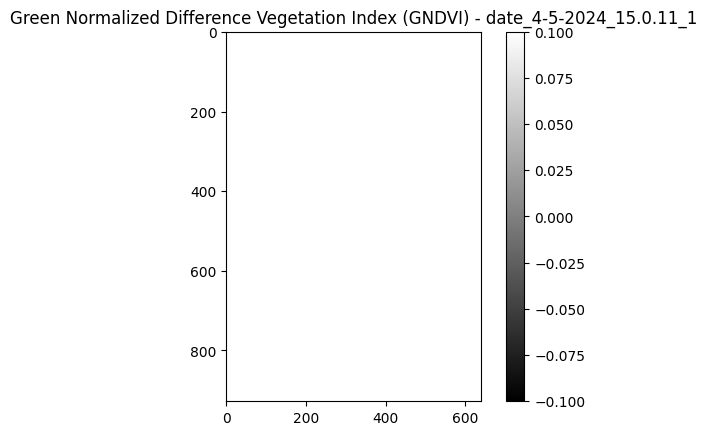

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Updated calibration data for 8 cameras
calibration_data = {
    'cam1': {'Blue': 10.77, 'Red': 12.24, 'Green': 12.57},
    'cam2': {'Blue': 12.18, 'Red': 11.67, 'Green': 13.82},
    'cam3': {'Blue': 11.58, 'Red': 11.35, 'Green': 12.63},
    'cam4': {'Blue': 11.27, 'Red': 10.99, 'Green': 12.49},
    'cam5': {'Blue': 11.22, 'Red': 12.59, 'Green': 14.87},
    'cam6': {'Blue': 11.13, 'Red': 11.10, 'Green': 12.04},
    'cam7': {'Blue': 11.36, 'Red': 11.35, 'Green': 12.53},
    'cam8': {'Blue': 11.00, 'Red': 12.27, 'Green': 14.01}
}

def vi(img, nir_x_center, nir_y_center, rgb_x_center, rgb_y_center, cam_name):
    # Split the image into NIR and RGB
    nir = img[:, :640, :].astype(np.float64)
    rgb = img[:, 641:1280, :].astype(np.float64)
    
    # Extract a 5x5 region around the RGB center coordinates
    rgb_gray = img[rgb_y_center - 5:rgb_y_center + 5, rgb_x_center - 5:rgb_x_center + 5, :]
    
    # Extract the red, green, and blue bands from the gray region
    rgb_gray_red, rgb_gray_green, rgb_gray_blue = rgb_gray[:, :, 2], rgb_gray[:, :, 1], rgb_gray[:, :, 0]
    rgb_gray_red_avg, rgb_gray_green_avg, rgb_gray_blue_avg = np.mean(rgb_gray_red), np.mean(rgb_gray_green), np.mean(rgb_gray_blue)
    
    # Convert the RGB image to red, green, blue bands
    red, green, blue = rgb[:, :, 2], rgb[:, :, 1], rgb[:, :, 0]
    rgb_red_ref, rgb_green_ref, rgb_blue_ref = (red / rgb_gray_red_avg), (green / rgb_gray_green_avg), (blue / rgb_gray_blue_avg)
    
    # Calculate the SCI (Soil Color Index)
    sci = (rgb_red_ref - rgb_green_ref) / (rgb_red_ref + rgb_green_ref)
    
    # Use the NIR image to calculate the GNDVI (Green Normalized Difference Vegetation Index)
    
    # Extract a 5x5 region around the NIR center coordinates
    nir_gray = img[nir_y_center - 5:nir_y_center + 5, nir_x_center - 5:nir_y_center + 5, :]
    
    # Extract the red, green, and blue bands from the gray region
    nir_gray_red, nir_gray_green, nir_gray_blue = nir_gray[:, :, 2], nir_gray[:, :, 1], nir_gray[:, :, 0]
    nir_gray_red_avg, nir_gray_green_avg, nir_gray_blue_avg = np.mean(nir_gray_red), np.mean(nir_gray_green), np.mean(nir_gray_blue)
    
    # Convert the NIR image to red, green, blue bands
    nir_red, nir_green, nir_blue = nir[:, :, 2], nir[:, :, 1], nir[:, :, 0]

    # Apply calibration factors if available
    if cam_name in calibration_data:
        calib_factors = calibration_data[cam_name]
        nir_red_ref = nir_red / (nir_gray_red_avg * (calib_factors.get('Red', 1) / 100))
        nir_green_ref = nir_green / (nir_gray_green_avg * (calib_factors.get('Green', 1) / 100))
        nir_blue_ref = nir_blue / (nir_gray_blue_avg * (calib_factors.get('Blue', 1) / 100))
    else:
        print(f'No calibration data found for {cam_name}')
        nir_red_ref, nir_green_ref, nir_blue_ref = nir_red, nir_green, nir_blue
    
    # Calculate the GNDVI
    gndvi = (nir_red_ref - nir_green_ref) / (nir_red_ref + nir_green_ref)
    
    return sci, gndvi

def process_cameras(base_path='../data/', cam_prefix='cam'):
    for i in range(1, 9):  # Assuming cameras are named from cam1 to cam8
        cam_name = f'{cam_prefix}{i}'
        csv_file = f'../model_output/{cam_name}.csv'
        cam_folder = os.path.join(base_path, cam_name)
        
        # Read the CSV file to get the center coordinates
        df = pd.read_csv(csv_file)
        
        # Separate NIR and RGB coordinates based on Center_X value
        nir_coords = df[df['Center_X'] > 640]
        rgb_coords = df[df['Center_X'] <= 640]
        
        # Assuming there's only one pair of coordinates for NIR and RGB in the CSV
        nir_x_center = nir_coords['Center_X'].values[0]
        nir_y_center = nir_coords['Center_Y'].values[0]
        rgb_x_center = rgb_coords['Center_X'].values[0]
        rgb_y_center = rgb_coords['Center_Y'].values[0]
        
        # Process each image in the camera folder
        for image_file in os.listdir(cam_folder):
            if image_file.lower().endswith(('.png')):
                image_path = os.path.join(cam_folder, image_file)
                
                # Load the image
                image = np.array(Image.open(image_path))
                
                # Call the vi function with the appropriate parameters
                sci, gndvi = vi(image, nir_x_center, nir_y_center, rgb_x_center, rgb_y_center, cam_name)
                
                # Save the results in the assets folder
                base_filename = os.path.splitext(image_file)[0]
                
                # plt.figure()
                # plt.imshow(sci, cmap='gray')
                # plt.title(f'Soil Color Index (SCI) - {base_filename}')
                # plt.colorbar()
                # plt.savefig(f'../assets/vi/sci/{cam_name}_{base_filename}.png')
                # plt.close()  # Close the figure to free memory
                
                plt.figure()
                plt.imshow(gndvi, cmap='gray')
                plt.title(f'Green Normalized Difference Vegetation Index (GNDVI) - {base_filename}')
                plt.colorbar()
                plt.savefig(f'../assets/vi/gndvi/{cam_name}_{base_filename}.png')
                plt.close()  # Close the figure to free memory

                print(f'Saved images for {cam_name}, {base_filename}')
                
# Process the camera images
process_cameras()